In [36]:
import pandas as pd
data = pd.read_csv("/kaggle/input/load-forecasting-dataset/load_forecasting_dataset_corrected.csv")

In [37]:
data.head()
import numpy as np

In [38]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189888 entries, 0 to 189887
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Timestamp                    189888 non-null  object 
 1   Temperature (°C)             189888 non-null  float64
 2   Humidity (%)                 189888 non-null  float64
 3   Wind Speed (m/s)             189888 non-null  float64
 4   Rainfall (mm)                189888 non-null  float64
 5   Solar Irradiance (W/m²)      189888 non-null  float64
 6   GDP (LKR)                    189888 non-null  float64
 7   Per Capita Energy Use (kWh)  189888 non-null  float64
 8   Electricity Price (LKR/kWh)  189888 non-null  float64
 9   Day of Week                  189888 non-null  int64  
 10  Hour of Day                  189888 non-null  int64  
 11  Month                        189888 non-null  int64  
 12  Season                       189888 non-null  object 
 13 

None

In [39]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = ((df['dayofmonth'] == 1) & (df['month'] % 3 == 1)).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max')).astype(int)


    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']

    return df

In [40]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

In [41]:
# Create features for the new data
if 'Timestamp' in data.columns:
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.set_index('Timestamp')

data = create_features(data)

# Convert 'Season' to numerical using one-hot encoding
if 'Season' in data.columns:
    data = pd.get_dummies(data, columns=['Season'], prefix='season', dtype=int)
else:
    print("Warning: 'Season' column not found in the DataFrame.")


# Convert remaining columns to float
data = data.astype(float)

# Display the first few rows with new features
display(data.head())

,Temperature (°C),Humidity (%),Wind Speed (m/s),Rainfall (mm),Solar Irradiance (W/m²),GDP (LKR),Per Capita Energy Use (kWh),Electricity Price (LKR/kWh),Day of Week,Hour of Day,...,is_quarter_start,is_quarter_end,is_working_day,is_business_hours,is_peak_hour,minute_of_day,minute_of_week,season_Fall,season_Summer,season_Winter
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,28.993428,75.011269,1.053861,4.140513,185.892561,925.621430,502.915605,20.454440,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,2880.0,0.0,1.0,0.0
2020-01-01 00:15:00,27.723471,77.024015,1.085152,9.446997,281.782650,1020.823521,497.286366,27.776449,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,15.0,2895.0,0.0,1.0,0.0
2020-01-01 00:30:00,29.295377,74.732958,3.363800,4.265813,328.942058,1028.847455,488.816292,21.097420,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,30.0,2910.0,0.0,1.0,0.0
2020-01-01 00:45:00,31.046060,87.615995,2.539148,1.038103,336.407064,937.963002,468.038834,26.032137,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,45.0,2925.0,0.0,1.0,0.0
2020-01-01 01:00:00,27.531693,79.709858,1.366819,4.201393,205.494256,934.477462,488.565716,27.079114,2.0,1.0,...,1.0,0.0,1.0,0.0,0.0,60.0,2940.0,0.0,1.0,0.0


In [42]:
# Add lag features
# ✅ Add lag features properly (15 min per step)
data["lag_1"] = data["Load Demand (kW)"].shift(1)   # 15 min ago
data["lag_2"] = data["Load Demand (kW)"].shift(2)   # 30 min ago
data["lag_3"] = data["Load Demand (kW)"].shift(3)   # 45 min ago
data["lag_4"] = data["Load Demand (kW)"].shift(4)   # 60 min ago
data["lag_5"] = data["Load Demand (kW)"].shift(5)   # 75 min ago

# Drop rows with NaN from lag creation
y = data["Load Demand (kW)"].shift(-1)
# data = data.dropna()

data = data.dropna()

In [43]:
display(data.tail())

,Temperature (°C),Humidity (%),Wind Speed (m/s),Rainfall (mm),Solar Irradiance (W/m²),GDP (LKR),Per Capita Energy Use (kWh),Electricity Price (LKR/kWh),Day of Week,Hour of Day,...,minute_of_day,minute_of_week,season_Fall,season_Summer,season_Winter,lag_1,lag_2,lag_3,lag_4,lag_5
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-05-31 22:45:00,27.433177,82.943227,1.564385,0.476854,214.276578,986.122824,487.823955,17.183842,5.0,22.0,...,1365.0,8565.0,1.0,0.0,0.0,1206.922957,1606.000890,1566.757374,1308.951265,1285.004133
2025-05-31 23:00:00,32.085127,84.159944,1.389473,0.309841,308.798749,970.258350,515.405431,29.773656,5.0,23.0,...,1380.0,8580.0,1.0,0.0,0.0,1443.317681,1206.922957,1606.000890,1566.757374,1308.951265
2025-05-31 23:15:00,27.620201,87.091108,2.722335,1.422315,282.487744,1007.429961,509.295868,24.883951,5.0,23.0,...,1395.0,8595.0,1.0,0.0,0.0,1908.512650,1443.317681,1206.922957,1606.000890,1566.757374
2025-05-31 23:30:00,29.378415,75.743129,2.317605,9.383305,246.291089,1019.239724,536.514530,27.765615,5.0,23.0,...,1410.0,8610.0,1.0,0.0,0.0,1462.020111,1908.512650,1443.317681,1206.922957,1606.000890
2025-05-31 23:45:00,27.737078,83.529497,0.914573,9.901955,299.088224,1020.425273,518.742211,15.496762,5.0,23.0,...,1425.0,8625.0,1.0,0.0,0.0,1637.841485,1462.020111,1908.512650,1443.317681,1206.922957


In [44]:
!pip install xgboost

from sklearn.model_selection import train_test_split

In [45]:
from sklearn.model_selection import train_test_split

In [47]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -----------------------------
# Train/Test Split
# -----------------------------
X = data.drop("Load Demand (kW)", axis=1)


min_len = min(len(X), len(y))

X = X[:min_len]
y = y[:min_len]
#y = data["Load Demand (kW)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [49]:
feature_cols = list(X_train.columns)
X_train

,Temperature (°C),Humidity (%),Wind Speed (m/s),Rainfall (mm),Solar Irradiance (W/m²),GDP (LKR),Per Capita Energy Use (kWh),Electricity Price (LKR/kWh),Day of Week,Hour of Day,...,minute_of_day,minute_of_week,season_Fall,season_Summer,season_Winter,lag_1,lag_2,lag_3,lag_4,lag_5
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:15:00,27.531726,79.342322,2.879259,8.921799,204.113322,906.307089,517.742133,26.050655,2.0,1.0,...,75.0,2955.0,0.0,1.0,0.0,1453.169325,1804.605971,1629.537708,1472.347140,1599.342831
2020-01-01 01:30:00,31.158426,71.645943,0.880808,0.544923,247.400541,800.427592,496.439128,23.220658,2.0,1.0,...,90.0,2970.0,0.0,1.0,0.0,1453.172609,1453.169325,1804.605971,1629.537708,1472.347140
2020-01-01 01:45:00,29.534869,85.227175,2.943079,1.550244,262.270821,1100.524882,520.289429,20.884973,2.0,1.0,...,105.0,2985.0,0.0,1.0,0.0,1815.842563,1453.172609,1453.169325,1804.605971,1629.537708
2020-01-01 02:00:00,27.061051,85.387375,3.005157,6.730992,321.956621,1052.210403,501.196614,30.661501,2.0,2.0,...,120.0,3000.0,0.0,1.0,0.0,1653.486946,1815.842563,1453.172609,1453.169325,1804.605971
2020-01-01 02:15:00,29.085120,82.334175,1.561072,3.680875,246.566294,932.621599,491.054875,31.952302,2.0,2.0,...,135.0,3015.0,0.0,1.0,0.0,1406.105123,1653.486946,1815.842563,1453.172609,1453.169325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 08:30:00,30.989155,76.658495,1.025629,4.494190,185.002179,969.730820,516.511264,26.283780,2.0,8.0,...,510.0,3390.0,1.0,0.0,0.0,1233.994847,1286.512628,1646.215627,1228.050084,1395.867411
2024-05-01 08:45:00,30.628229,76.831687,2.418424,3.048316,287.671736,1078.486252,476.881974,25.425581,2.0,8.0,...,525.0,3405.0,1.0,0.0,0.0,1798.915461,1233.994847,1286.512628,1646.215627,1228.050084
2024-05-01 09:00:00,28.667696,70.659790,0.932199,2.201661,271.286846,1037.158669,515.655415,19.317195,2.0,9.0,...,540.0,3420.0,1.0,0.0,0.0,1762.822918,1798.915461,1233.994847,1286.512628,1646.215627


In [57]:
# -----------------------------
# Model
# -----------------------------
model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# -----------------------------
# Train
# -----------------------------
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# -----------------------------
# Predict
# -----------------------------
y_pred = model.predict(X_test)

# -----------------------------
# Metrics
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Avoid division by zero in MAPE
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-9, y_test))) * 100

r2 = r2_score(y_test, y_pred)

print("\n==============================")
print("   📊 Model Performance Report")
print("==============================\n")

print("✅ Test Set Evaluation (XGBoost Regressor)")
print(f"• RMSE (Typical error magnitude)      : {rmse:.2f} kW")
print(f"• MAE  (Average absolute deviation)   : {mae:.2f} kW")
print(f"• MAPE (Average percentage error)     : {mape:.2f}%")
print(f"• R²   (Explained variance / Fit)     : {r2:.4f}")

print("\n📌 Interpretation:")
print(f"→ On average, the model deviates by about {mae:.2f} kW from the actual demand.")
print(f"→ Typical prediction error (RMSE) is around {rmse:.2f} kW.")
print(f"→ The model explains approximately {r2*100:.2f}% of the variation in electricity demand.")


[0]	validation_0-rmse:189.50686
[50]	validation_0-rmse:23.89717
[100]	validation_0-rmse:5.87735
[150]	validation_0-rmse:5.38941
[200]	validation_0-rmse:5.41244
[250]	validation_0-rmse:5.45561
[300]	validation_0-rmse:5.46917
[350]	validation_0-rmse:5.47750
[400]	validation_0-rmse:5.48207
[450]	validation_0-rmse:5.48229
[499]	validation_0-rmse:5.48240

   📊 Model Performance Report

✅ Test Set Evaluation (XGBoost Regressor)
• RMSE (Typical error magnitude)      : 5.48 kW
• MAE  (Average absolute deviation)   : 1.68 kW
• MAPE (Average percentage error)     : 0.12%
• R²   (Explained variance / Fit)     : 0.9992

📌 Interpretation:
→ On average, the model deviates by about 1.68 kW from the actual demand.
→ Typical prediction error (RMSE) is around 5.48 kW.
→ The model explains approximately 99.92% of the variation in electricity demand.


In [51]:
import pandas as pd

def predict_load_api(payload: dict, model, feature_cols):
    """
    payload (dict) example:

    {
        
    "Timestamp": "2025-05-20 18:15:00",

    "Temperature (°C)": 30.2,
    "Humidity (%)": 74.5,
    "Wind Speed (m/s)": 2.3,
    "Rainfall (mm)": 0.0,
    "Solar Irradiance (W/m²)": 120.0,

    "GDP (LKR)": 100000000,
    "Per Capita Energy Use (kWh)": 1200,
    "Electricity Price (LKR/kWh)": 45.0,

    "Day of Week": 1,          # 0=Mon, 6=Sun
    "Hour of Day": 18,         # 0-23
    "Month": 5,                # 1-12
    "Season": "Summer",        # must match training values exactly
    "Public Event": 0,

    "lag_1": 23000,
    "lag_2": 22500,
    "lag_3": 21000,
    "lag_4": 20000,
    "lag_5" : 5666,
    
    }
    
    Returns predicted Load Demand (kW)
    """

    # Convert payload dict to dataframe
    df = pd.DataFrame([payload])

    # Timestamp must be present
    if "Timestamp" not in df.columns:
        raise ValueError("Payload must contain 'Timestamp'")

    # Set timestamp index
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.set_index("Timestamp")

    # Create time features
    df = create_features(df)

    # Make sure any missing columns are handled
    df = df.reindex(columns=feature_cols, fill_value=0)

    # Predict
    pred = model.predict(df)[0]
    return float(pred)


lag_1= 23000
lag_2= 23000
lag_3= 2300
lag_4= 23000
lag_5= 23000

sample_payload = {
    "Timestamp": "2025-05-20 18:15:00",

    "Temperature (°C)": 30.2,
    "Humidity (%)": 74.5,
    "Wind Speed (m/s)": 2.3,
    "Rainfall (mm)": 0.0,
    "Solar Irradiance (W/m²)": 120.0,

    "GDP (LKR)": 100000000,
    "Per Capita Energy Use (kWh)": 1200,
    "Electricity Price (LKR/kWh)": 45.0,

    "Day of Week": 1,          # 0=Mon, 6=Sun
    "Hour of Day": 18,         # 0-23
    "Month": 5,                # 1-12
    "Season": "Summer",        # must match training values exactly
    "Public Event": 0,

    "lag_1": int(lag_1),
    "lag_2": lag_2,
    "lag_3": lag_3,
    "lag_4": lag_4,
    "lag_5": lag_5
}

out = predict_load_api(sample_payload, model, feature_cols)
print(out)





lag_5= lag_4

lag_4= lag_3

lag_3= lag_2

lag_2= lag_1

lag_1= out

2093.156982421875


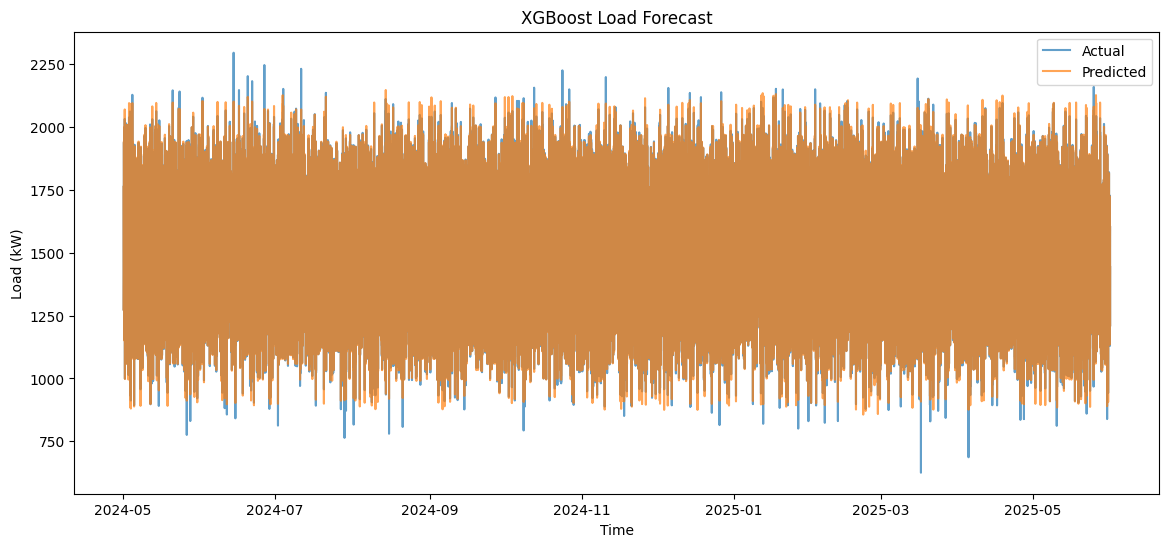

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("XGBoost Load Forecast")
plt.xlabel("Time")
plt.ylabel("Load (kW)")
plt.show()

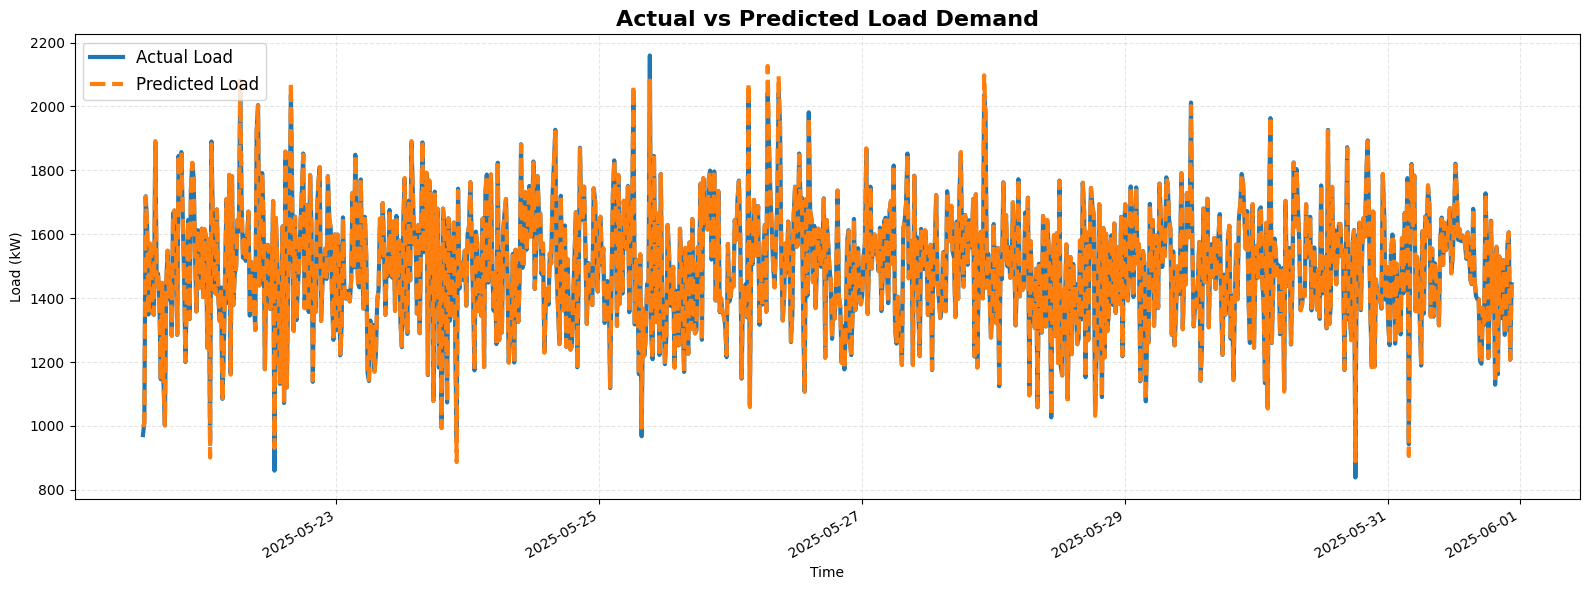

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

n = 1000  # last 100 points

# ensure y_pred is a series aligned to y_test index
y_pred_series = pd.Series(y_pred, index=y_test.index)

# take last n points
y_true_n = y_test.iloc[-n:]
y_pred_n = y_pred_series.loc[y_true_n.index]

plt.figure(figsize=(16,6))

plt.plot(y_true_n.index, y_true_n.values, label="Actual Load", linewidth=3)
plt.plot(y_pred_n.index, y_pred_n.values, label="Predicted Load", linestyle="--", linewidth=3)

plt.title("Actual vs Predicted Load Demand", fontsize=16, weight="bold")
plt.xlabel("Time")
plt.ylabel("Load (kW)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.xticks(rotation=30, ha="right")
plt.legend(fontsize=12, loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# print(data.iloc[5, -6:-1])

In [ ]:
# print(data.iloc[5,:])

In [ ]:
# lags = [23000, 23000, 2300, 23000, 23000]  # [lag_1, lag_2, lag_3, lag_4, lag_5]

# for step in range(20):
#     sample_payload["lag_1"] = lags[0]
#     sample_payload["lag_2"] = lags[1]
#     sample_payload["lag_3"] = lags[2]
#     sample_payload["lag_4"] = lags[3]
#     sample_payload["lag_5"] = lags[4]

#     out = predict_load_api(sample_payload, model, feature_cols)
#     print(f"Step {step+1} => {out:.2f}")

#     # ✅ shift
#     lags = [out] + lags[:4]

In [ ]:
import joblib
joblib.dump(model, "xgb_model.pkl")
joblib.dump(feature_cols, "feature_cols.pkl")
print("✅ Saved model and feature cols")